In [38]:
import os

PATH = "/cmlscratch/ani01/.cache/huggingface"
os.environ['HF_HOME'] = PATH
os.environ['TRANSFORMERS_CACHE'] = PATH + "/" + "models"
os.environ['HF_DATASETS_CACHE'] = PATH + "/" + "datasets"
os.environ['TORCH_HOME'] = "/cmlscratch/ani01/.cache/torch"

In [18]:
# from utils.vlm_helper import VLMInference
# from utils.prompt_templates import PROMPTS
# from utils.viz_utils import show_chart_pair, show_alignment_json

import sys, os

# Add project root to sys.path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25
from utils.prompt_templates import PROMPT_TEMPLATES

In [19]:
from datasets import load_dataset
import json
from PIL import Image

from IPython.display import display

In [20]:
def get_chart_pair_images(img):

    width, height = img.size
    midpoint = width // 2

    left_box = (0, 0, midpoint, height)
    chart_1_img = img.crop(left_box)

    right_box = (midpoint, 0, width, height)
    chart_2_img = img.crop(right_box)

    return chart_1_img, chart_2_img

In [21]:
dataset = load_dataset("aniruddhbansal2000/sample_dataset", "data_grounding_and_alignment")["test"]

In [22]:
# !nvitop

In [23]:
sample = dataset[87]
sample

{'idx': 87,
 'imgname': 'bar_241',
 'chart_type': 'bar_chart',
 'num_cell_difference': 2,
 'chart_1_grounding': 'Product \t Online sales(million) \t Retail sales(million) \n Shoes \t 42 \t 50 \n Clothes \t 65 \t 80 \n Bags \t 35 \t 45 \n Accessories \t 21 \t 30 \n ',
 'chart_2_grounding': 'Product \t Online sales(million) \t Retail sales(million) \n Shoes \t 20 \t 50 \n Clothes \t 65 \t 76 \n Bags \t 35 \t 45 \n Accessories \t 21 \t 30 \n ',
 'alignment_json': '{"0": {"row name": "Shoes", "column name": "Online sales(million)", "value in chart 1": 42, "value in chart 2": 20}, "1": {"row name": "Clothes", "column name": "Retail sales(million)", "value in chart 1": 80, "value in chart 2": 76}}',
 'image_pair': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1600x500>}

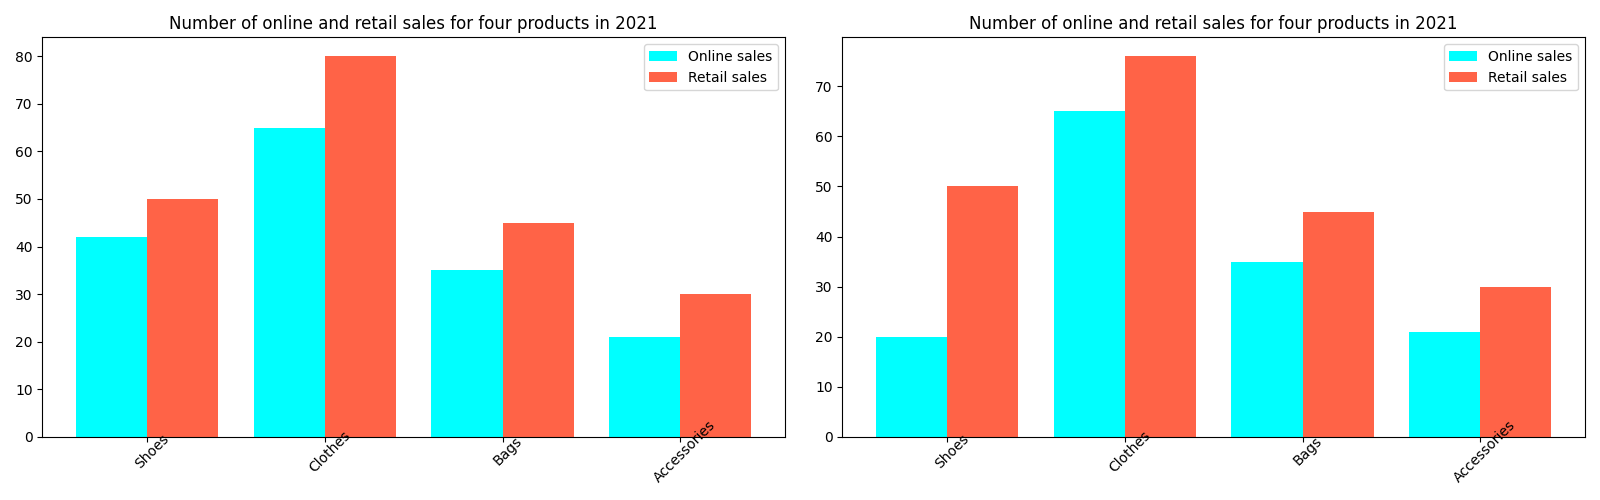

In [24]:
img = sample["image_pair"]
img

In [25]:
chart_1_img, chart_2_img = get_chart_pair_images(img)
chart_1_img, chart_2_img

(<PIL.Image.Image image mode=RGB size=800x500>,
 <PIL.Image.Image image mode=RGB size=800x500>)

In [26]:
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
data_grounding_prompt = PROMPT_TEMPLATES["data"]["grounding"]

chart_1_predicted_grounding = VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_1_img])
chart_2_predicted_grounding = VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_2_img])

In [28]:
print(f"chart 1 predicted grounding: {chart_1_predicted_grounding}")
print(f"chart 1 ground-truth grounding: {sample['chart_1_grounding']}")

print(f"chart 2 predicted grounding: {chart_2_predicted_grounding}")
print(f"chart 2 ground-truth grounding: {sample['chart_2_grounding']}")

chart 1 predicted grounding: 
Product,Online Sales,Retail Sales
Shoes,42,50
Clothes,63,80
Bags,35,45
Accessories,22,30

chart 1 ground-truth grounding: Product 	 Online sales(million) 	 Retail sales(million) 
 Shoes 	 42 	 50 
 Clothes 	 65 	 80 
 Bags 	 35 	 45 
 Accessories 	 21 	 30 
 
chart 2 predicted grounding: 
Product,Online Sales,Retail Sales
Shoes,20,50
Clothes,60,70
Bags,35,45
Accessories,22,30

chart 2 ground-truth grounding: Product 	 Online sales(million) 	 Retail sales(million) 
 Shoes 	 20 	 50 
 Clothes 	 65 	 76 
 Bags 	 35 	 45 
 Accessories 	 21 	 30 
 


Product,Online sales,Retail sales
Shoes,42,50
Clothes,65,80
Bags,35,45
Accessories,21,30
Product,Online Sales,Retail Sales
Shoes,42,50
Clothes,63,80
Bags,35,45
Accessories,22,30
Product,Online sales,Retail sales

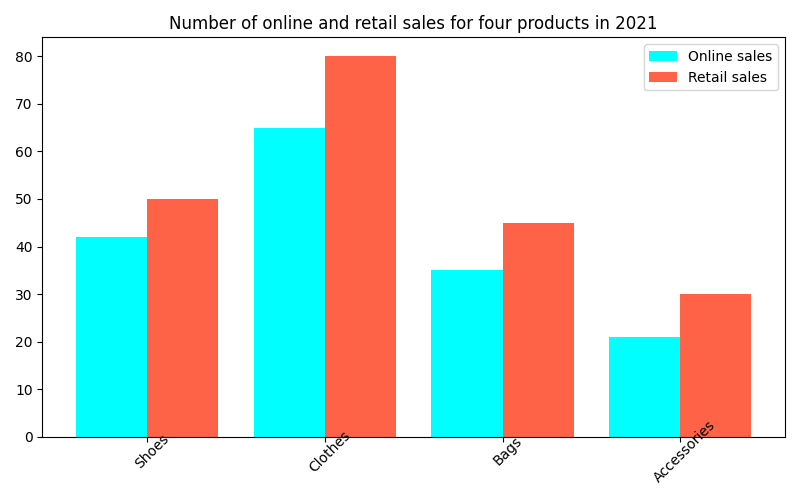
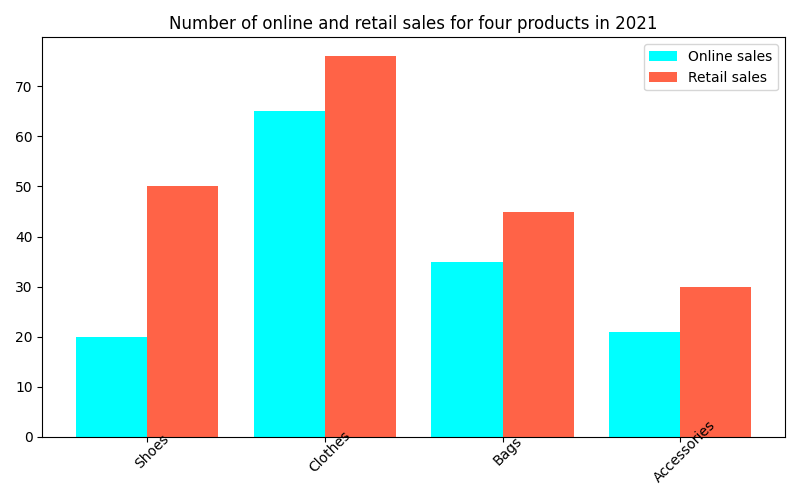

In [103]:
from IPython.display import display, HTML
import pandas as pd
import io
import base64

def show_chart_with_groundings(chart1_img, chart2_img, chart1_gt, chart1_pred, chart2_gt, chart2_pred):
    """
    Display two charts side by side, with ground-truth and predicted grounding tables beneath each.
    chart*_img can be file paths or PIL.Image objects.
    chart*_gt / chart*_pred are CSV strings.
    """

    def img_to_base64(img):
        if isinstance(img, str):  # file path
            with open(img, "rb") as f:
                data = f.read()
        else:  # PIL Image
            from io import BytesIO
            buf = BytesIO()
            img.save(buf, format="PNG")
            data = buf.getvalue()
        return base64.b64encode(data).decode("utf-8")

    def csv_to_html_table(csv_str):
        csv_str = csv_str.replace("\t", ",").replace("(million)", "")
        csv_str = "\n".join(
            [",".join(col.strip() for col in line.split(",")) for line in csv_str.strip().splitlines() if line.strip()]
        )
        df = pd.read_csv(io.StringIO(csv_str), dtype=str)
        return df.to_html(index=False, escape=False, border=1)

    # Convert images to base64 HTML <img>
    chart1_b64 = img_to_base64(chart1_img)
    chart2_b64 = img_to_base64(chart2_img)

    chart1_html = f"""
    <div style="text-align:center; width:48%; display:inline-block; vertical-align:top;">
        <img src="data:image/png;base64,{chart1_b64}" style="max-width:100%; border:1px solid #ccc; border-radius:8px;"><br>
        <h4>Chart 1 — Ground Truth Grounding</h4>
        {csv_to_html_table(chart1_gt)}
        <h4>Chart 1 — Predicted Grounding</h4>
        {csv_to_html_table(chart1_pred)}
    </div>
    """

    chart2_html = f"""
    <div style="text-align:center; width:48%; display:inline-block; vertical-align:top;">
        <img src="data:image/png;base64,{chart2_b64}" style="max-width:100%; border:1px solid #ccc; border-radius:8px;"><br>
        <h4>Chart 2 — Ground Truth Grounding</h4>
        {csv_to_html_table(chart2_gt)}
        <h4>Chart 2 — Predicted Grounding</h4>
        {csv_to_html_table(chart2_pred)}
    </div>
    """

    html = f"""
    <div style="display:flex; justify-content:space-between; gap:2%; margin-top:10px;">
        {chart1_html}
        {chart2_html}
    </div>
    """

    display(HTML(html))

show_chart_with_groundings(chart_1_img, chart_2_img, sample['chart_1_grounding'], chart_1_predicted_grounding, sample['chart_2_grounding'], chart_2_predicted_grounding)


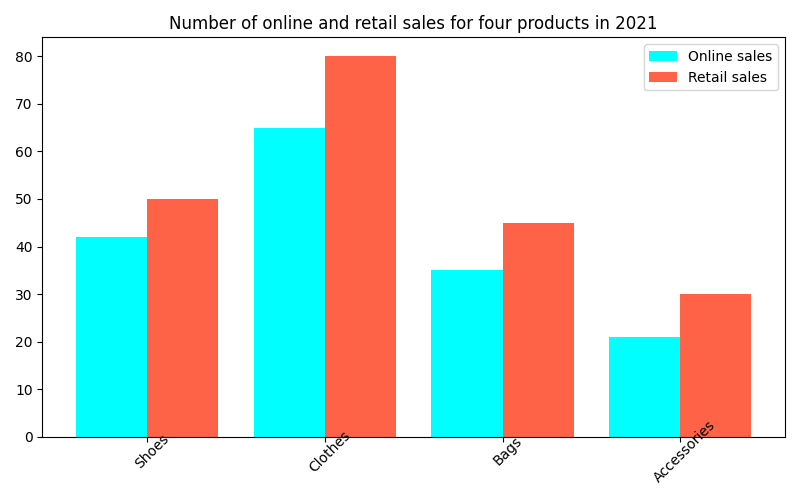

Chart 1: GT Grounding


,Product,Online sales,Retail sales
0,Shoes,20,50
1,Clothes,65,76
2,Bags,35,45
3,Accessories,21,30


,Product,Online Sales,Retail Sales
0,Shoes,20,50
1,Clothes,60,70
2,Bags,35,45
3,Accessories,22,30


{(1, 'Online Sales', '60'), (0, 'Retail Sales', '50'), (3, 'Retail Sales', '30'), (2, 'Retail Sales', '45'), (0, 'Online Sales', '20'), (3, 'Online Sales', '22'), (1, 'Retail Sales', '70'), (2, 'Online Sales', '35')}
{(0, 'Retail sales', '50'), (3, 'Online sales', '21'), (2, 'Retail sales', '45'), (0, 'Online sales', '20'), (3, 'Retail sales', '30'), (1, 'Online sales', '65'), (1, 'Retail sales', '76'), (2, 'Online sales', '35')}


In [102]:
import pandas as pd
from IPython.display import display, HTML
import io

display(chart_1_img)

def clean_csv_string(csv_str):
    # Remove units and excess whitespace
    csv_str = csv_str.replace("(million)", "")
    csv_str = csv_str.replace("\t", ",")
    # Remove double spaces and trim
    csv_str = "\n".join([",".join(col.strip() for col in line.split(",")) 
                         for line in csv_str.strip().splitlines() if line.strip()])
    return csv_str


def df_to_triplets(df):
    return set((r, c, str(df.at[r, c])) for r in df.index for c in df.columns)

def show_grounding_comparison(gt_grounding, pred_grounding):
    import pandas as pd, io
    gt_csv = clean_csv_string(gt_grounding)
    pred_csv = clean_csv_string(pred_grounding)

    gt_df = pd.read_csv(io.StringIO(gt_csv), dtype=str)
    pred_df = pd.read_csv(io.StringIO(pred_csv), dtype=str)

    print("Chart 1: GT Grounding")
    display(gt_df)
    display(pred_df)

    gt_triples = df_to_triplets(gt_df)
    pred_triples = df_to_triplets(pred_df)
    
    added = pred_triples - gt_triples
    missing = gt_triples - pred_triples

    print(added)
    print(missing)

    # differences = gt_df.compare(pred_df, keep_equal=False, result_names=('GT', 'Pred'))
    # display(differences)



# def show_grounding_comparison(gt_grounding, pred_grounding):
    
#     gt_grounding = gt_grounding.replace("\t", ",").replace("(million)", "")
#     pred_grounding = pred_grounding[1:]

#     gt_df = pd.read_csv(io.StringIO(gt_grounding), dtype=str)
#     predicted_df = pd.read_csv(io.StringIO(pred_grounding), dtype=str)

#     print(gt_df)
#     print(predicted_df)

#     differences = gt_df.compare(predicted_df, keep_equal=False, result_names=('file1', 'file2'))
#     print(differences)
    
#     # df = pd.DataFrame({
#     #     "Ground Truth Grounding": gt_grounding.split("\n"),
#     #     "Predicted Grounding": pred_grounding.split("\n")
#     # })
#     # display(HTML(df.to_html(index=False)))

show_grounding_comparison(sample['chart_2_grounding'], chart_2_predicted_grounding)

In [60]:
def extract_json_from_data_alignment_res(predicted_alignment, num_cell_difference):

    predicted_alignment = predicted_alignment.replace('\n', '')
    predicted_alignment_json = {}

    for i in range(num_cell_difference):
        
        chart_change_json_element = None
        try:
            idx_start = predicted_alignment.find('{')
            idx_end = predicted_alignment.find('}') + 1
            json_part = predicted_alignment[idx_start:idx_end]

            # print(json_part)

            predicted_alignment = predicted_alignment.replace(json_part, "*", 1)
            chart_change_json_element = json.loads(json_part)

        except:
            chart_change_json_element = {}
            chart_change_json_element["row name"] = "sample row"
            chart_change_json_element["column name"] = "sample column"
            chart_change_json_element["value in chart 1"] = float('inf')
            chart_change_json_element["value in chart 2"] = float('inf')


        predicted_alignment_json[i] = chart_change_json_element
    
    return predicted_alignment_json

In [66]:
predicted_alignment_json = extract_json_from_data_alignment_res(predicted_alignment, 2)
print(predicted_alignment_json)

json_str = json.dumps(predicted_alignment_json)
print(json_str)

json_from_str = json.loads(json_str)
print(json_from_str)

{0: {'row name': 'Shoes', 'column name': 'Online Sales', 'value in chart 1': 42, 'value in chart 2': 20}, 1: {'row name': 'Clothes', 'column name': 'Retail Sales', 'value in chart 1': 80, 'value in chart 2': 70}}
{"0": {"row name": "Shoes", "column name": "Online Sales", "value in chart 1": 42, "value in chart 2": 20}, "1": {"row name": "Clothes", "column name": "Retail Sales", "value in chart 1": 80, "value in chart 2": 70}}
{'0': {'row name': 'Shoes', 'column name': 'Online Sales', 'value in chart 1': 42, 'value in chart 2': 20}, '1': {'row name': 'Clothes', 'column name': 'Retail Sales', 'value in chart 1': 80, 'value in chart 2': 70}}


In [55]:
num_cell_difference = sample["num_cell_difference"]

data_alignment_prompt = PROMPT_TEMPLATES["data"]["alignment"]
data_alignment_prompt = data_alignment_prompt.replace("image_1_predicted_grounding_tag", chart_1_predicted_grounding)
data_alignment_prompt = data_alignment_prompt.replace("image_2_predicted_grounding_tag", chart_2_predicted_grounding)
data_alignment_prompt = data_alignment_prompt.replace("cells_change_cnt_tag", str(num_cell_difference))
if num_cell_difference == 1: # singular
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cell")
else:                     # plural
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cells")

predicted_alignment = VLM_obj.infer(prompt_text_template = data_alignment_prompt)

print(f"predicted alignment is: {predicted_alignment}")
print(f"ground-truth alignment is: {sample['alignment_json']}")

predicted alignment is: [{"row name": "Shoes", "column name": "Online Sales", "value in chart 1": 42, "value in chart 2": 20}, {"row name": "Clothes", "column name": "Retail Sales", "value in chart 1": 80, "value in chart 2": 70}]
ground-truth alignment is: {"0": {"row name": "Shoes", "column name": "Online sales(million)", "value in chart 1": 42, "value in chart 2": 20}, "1": {"row name": "Clothes", "column name": "Retail sales(million)", "value in chart 1": 80, "value in chart 2": 76}}


In [33]:
# DONE: 1. import prompt, add images/grounding information
# 2. process extracted json
# 3. visualize?

# phi_35_model()

In [34]:
sample["alignment_json"]

'{"0": {"row name": "Shoes", "column name": "Online sales(million)", "value in chart 1": 42, "value in chart 2": 20}, "1": {"row name": "Clothes", "column name": "Retail sales(million)", "value in chart 1": 80, "value in chart 2": 76}}'

In [35]:
PROMPT_TEMPLATES["data"]

{'grounding': 'Given a chart image: image_1_tag\nGenerate the table (csv format) for the chart data. Only output the table directly.',
 'alignment': 'Given table (csv format) for first chart:-\nimage_1_predicted_grounding_tag\nGiven table (csv format) for second chart:-\nimage_2_predicted_grounding_tag\nThe second chart differs from first due to change in value of cells_change_cnt_tag of the cell(s). Can you identify the cells_change_cnt_tag cell(s)? Mention final answer of form: "[<cell i json> for for all i cells with value change]" where json is of form: {"row name": <row name for the cell>, "column name": <column name for the cell>, "value in chart 1": <cell value in chart 1>, "value in chart 2": <cell value in chart 2>}. Only cells_change_cnt_tag cell(s) hence output only cells_change_cnt_tag json in list, no explaination needed.'}